In [52]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pylab
from scipy.signal import lfilter
from scipy.signal import TransferFunction
from scipy.signal import ZerosPolesGain
from scipy.signal import sawtooth
from scipy.signal import freqz
from scipy.fftpack import *
from control.matlab import *

# 3.2.1. 
Разработайте функцию DFT, вычисляющую ДПФ от входного вектора, не используя функцию MatlabFFT, и рисующую графики действительной
и мнимой частей результата преобразования. Сравните результаты работы своей функции с функцией Matlab FFT.

Формула синусоиды в функции *generate_sinusoid*:
$$x[n] = A \cos(2 \pi f n T + \varphi) x[n] = A \cos(2 \pi f n T + \varphi)$$

In [84]:
def generate_sinusoid(N, A, f0, fs, phi):
    '''
    N(int)     : Количество образцов
    A(float)   : Амплитуда
    f0(float)  : Частота в герцах
    fs(float)  : Частота дискретизации
    phi(float) : Начальная фаза
    
    return 
    x (numpy array) : синусоидальный сигнал, длина которого равна M
    '''
    T = 1/fs
    n = np.arange(N)    # [0,1,..., N-1]
    x = A * np.sin(2 * f0 * np.pi * n * T + phi)
    return x

In [85]:
# Другой способ генерировать синусоидальный сигнал, генерировать последовательность длительностью t
def generate_sinusoid_2(t, A, f0, fs, phi):
    '''
    t (float)  : продолжительность сгенерированной последовательности
    A(float)   : Амплитуда
    f0(float)  : Частота в герцах
    fs(float)  : Частота дискретизации
    phi(float) : Начальная фаза
    
    returns
    x (numpy array): синусоидальный сигнал
    '''
    T = 1.0/fs
    N = t / T
    return generate_sinusoid(N, A, f0, fs, phi)

In [86]:
def generate_complex_sinusoid(k, N):
    '''
    k (int): Частотный индекс
    N (int): Длина комплексной синусоиды
    
    returns
    c_sin (numpy array): Сгенерированная комлексная синусоида длины N
    '''
    n = np.arange(N)
    c_sin = np.exp(1j * 2 * np.pi * k * n / N)
    return np.conjugate(c_sin)

In [87]:
def generate_complex_sinusoid_matrix(N):
    '''
    N (int): Длина комплексной синусоиды
    
    returns
    c_sin_matrix (numpy array): Сгенерированная комплексная синусоида
    '''
    n = np.arange(N)
    n = np.expand_dims(n, axis=1)      # Расширить размер, преобразовать 1D вектор в 2D матрицу, чтобы облегчить умножение матрицы
    k = n
    m = n.T * k / N                    # [N,1] * [1, N] = [N,N]
    S = np.exp(1j * 2 * np.pi * m)     # Матрица расчета S
    return np.conjugate(S)

In [88]:
def myDFT(N, A, f0, fs, phi):
    x = generate_sinusoid(N, A, f0, fs, phi)
    X = np.array([])
    for k in range(N):
        s = generate_complex_sinusoid(k, N)
        X = np.append(X, np.sum(x * s))
    return X

In [89]:
N = 511
A = 0.8
f0 = 440
fs = 44100
phi = 1.0

# FFT library
X0 = fft(generate_sinusoid(N, A, f0, fs, phi))
mX0 = np.abs(X0)
pX0 = np.angle(X0)

# myDFT
X1 = myDFT(N, A, f0, fs, phi)
mX1 = np.abs(X1)
pX1 = np.angle(X1)

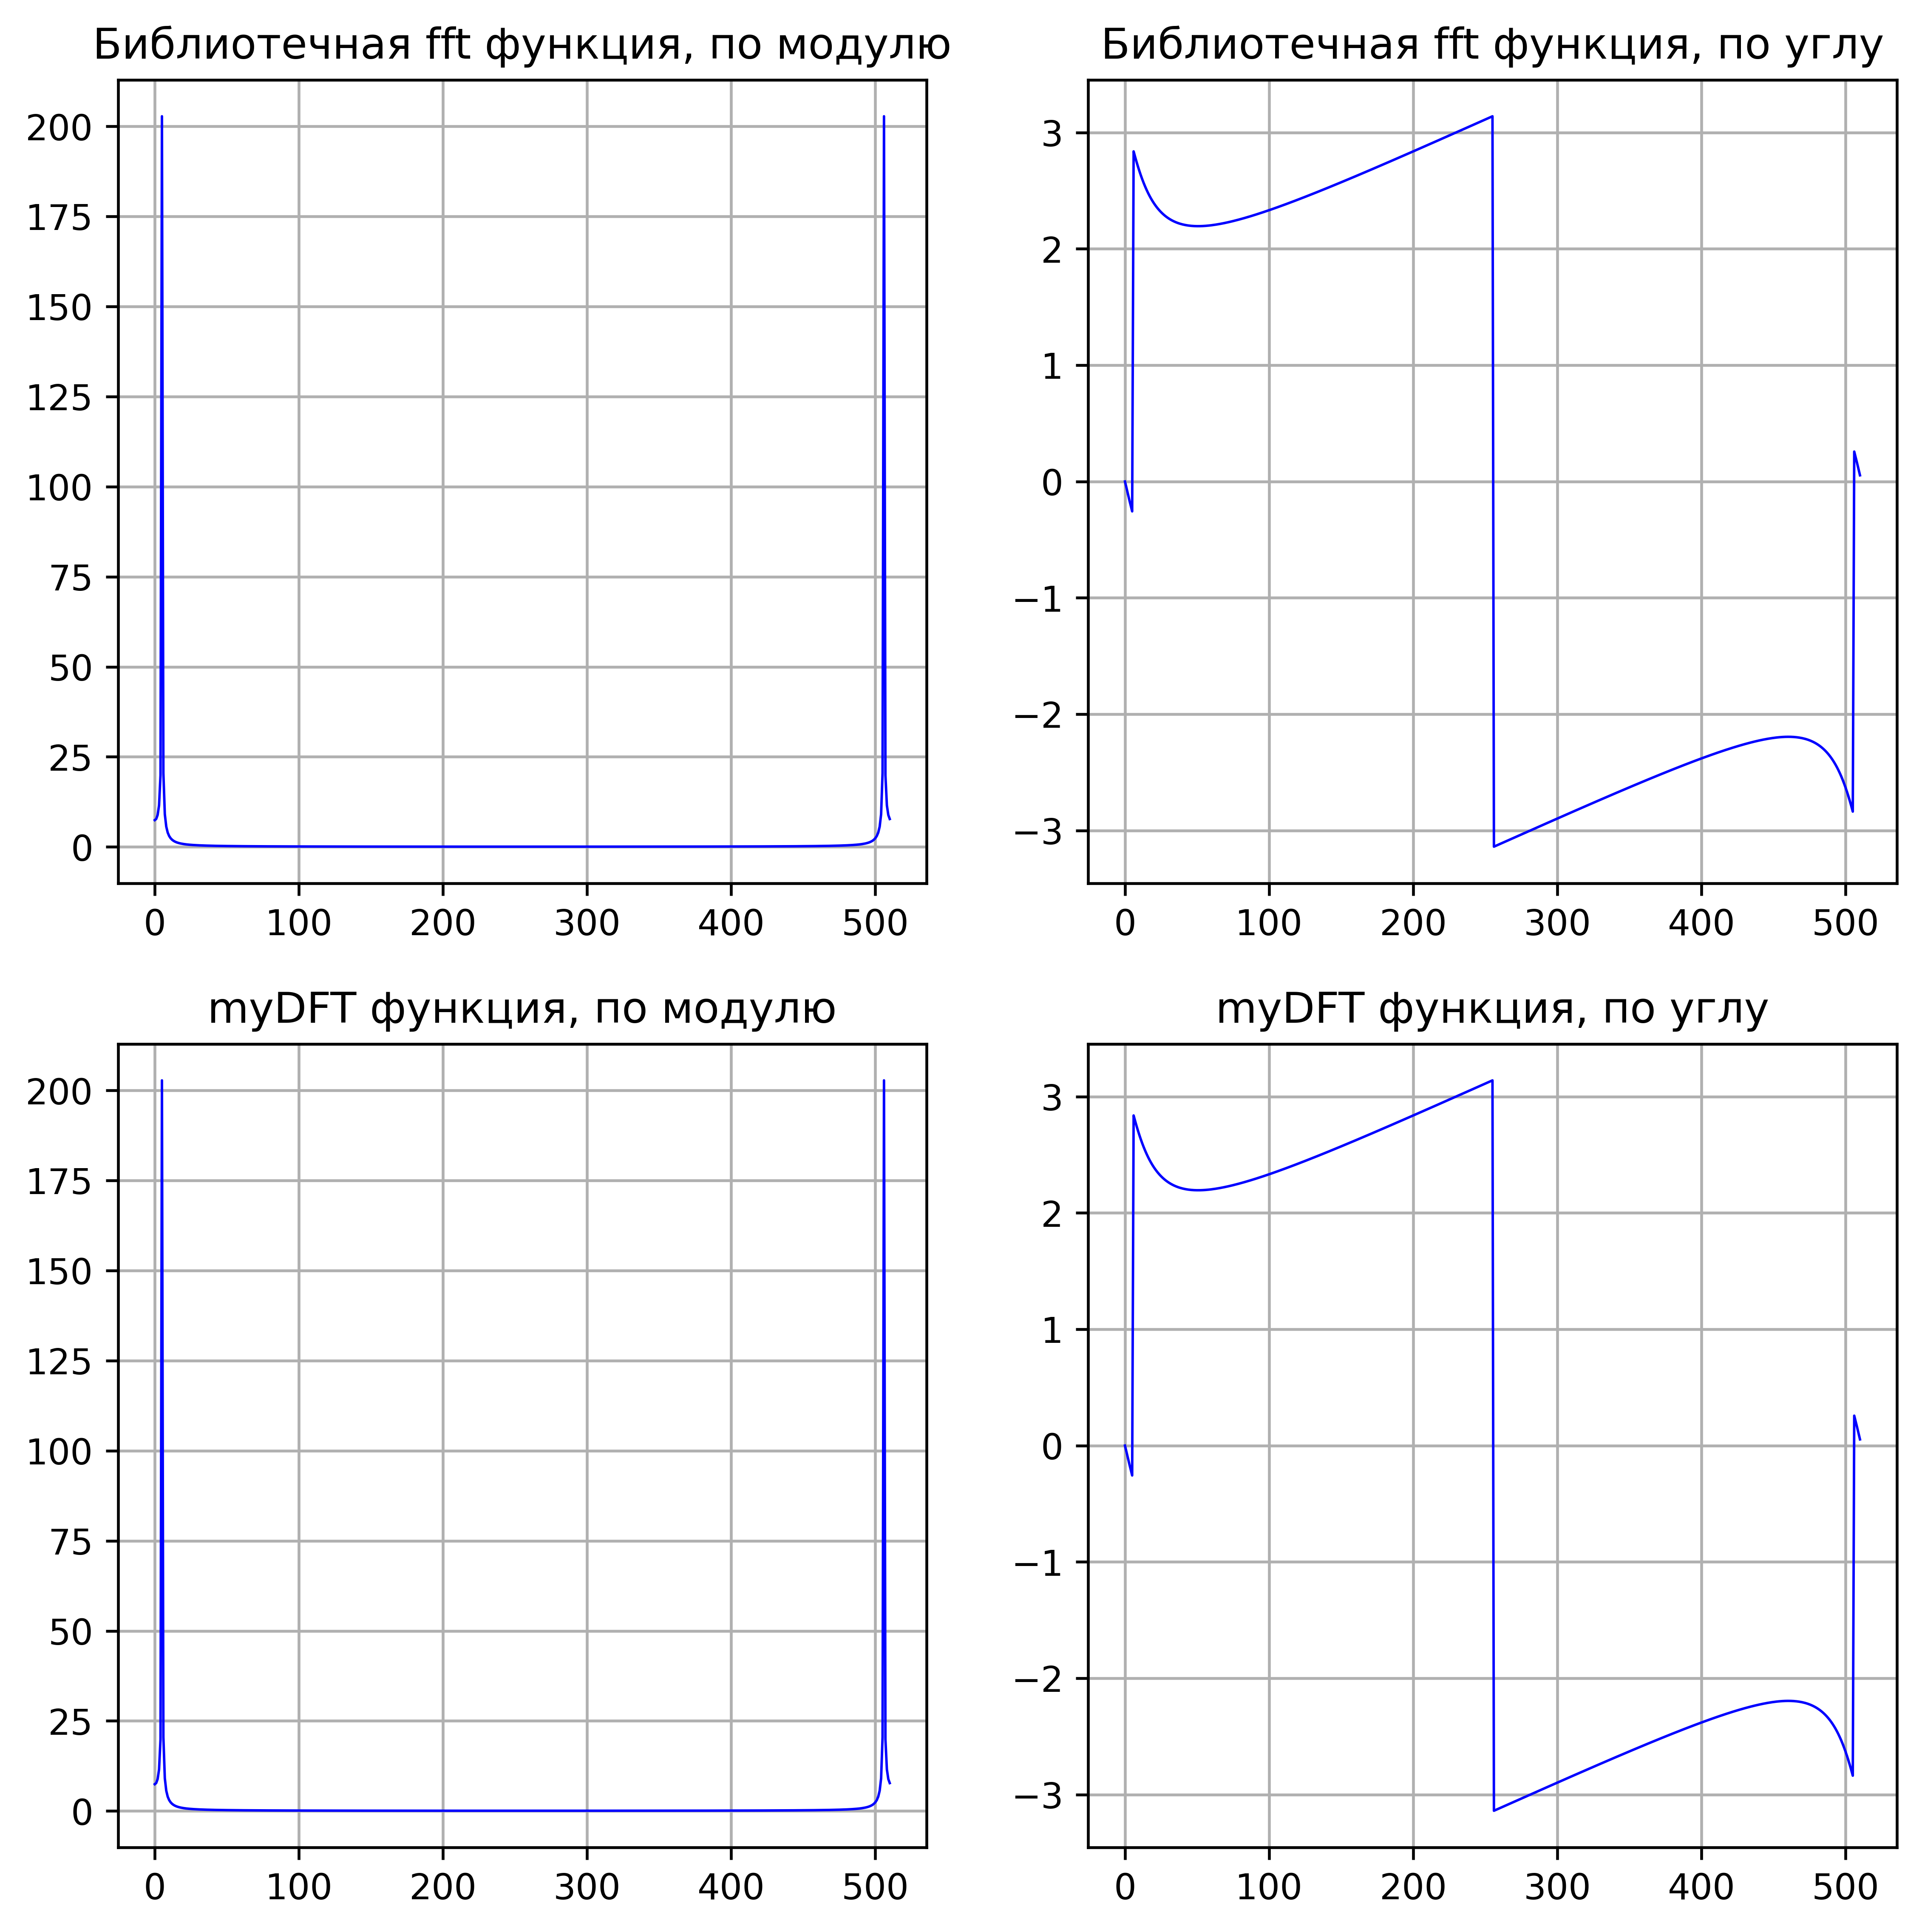

In [137]:
pylab.figure(figsize=(9.0, 9.0), dpi=600)
Linewidth=0.7
pylab.subplot(2, 2, 1)
pylab.plot(mX0, linestyle='-', color='b', linewidth=Linewidth)
pylab.grid()
pylab.title('Библиотечная fft функция, по модулю')

pylab.subplot(2, 2, 2)
pylab.plot(pX0, linestyle='-', color='b', linewidth=Linewidth)
pylab.grid()
pylab.title('Библиотечная fft функция, по углу')

pylab.subplot(2, 2, 3)
pylab.plot(mX1, linestyle='-', color='b', linewidth=Linewidth)
pylab.grid()
pylab.title('myDFT функция, по модулю')

pylab.subplot(2, 2, 4)
pylab.plot(pX1, linestyle='-', color='b', linewidth=Linewidth)
pylab.grid()
pylab.title('myDFT функция, по углу')
pylab.savefig('myDFT.png', dpi = 600)
pylab.show()

# 3.2.2. 
Предположим, что задан входной сигнал 𝑥[𝑛]изначения ДПФ сигнала 𝑋(𝑘). Разработайте в среде Matlab функцию [cA, sA]=SinCosAmps(X),
которая из комплексных значений 𝑋(𝑘) вычисляет амплитуды косинусов и синусов, на которые раскладывается сигнал𝑥[𝑛]. Если входной сигнал имеет размерность 𝑁, то выходные массивы cA и sA должны иметь размерность 𝑁/2+1.

In [59]:
def SinCosAmps(X):
    N = len(X)
    cA = np.zeros((N//2 + 1,), dtype=np.float64)
    sA = np.zeros((N//2 + 1,), dtype=np.float64)
    
    cA[0] = np.abs(X[0])/N
    cA[N//2] = np.abs(X[N//2])/N
    
    for k in range(1, N//2):
        cA[k] = np.abs(X[k])/N
        sA[k] = np.abs(X[N-k])/N
    
    return cA, sA

In [63]:
x_ = X0[1:10]
print("x:", x_)
cA, sA = SinCosAmps(X0[1:10])
print("Amplitudes of cosines:", cA)
print("Amplitudes of sines:", sA)

x: [ 2.32345826  +1.53069779j  2.60839969  +3.4788446j
  3.30686692  +6.75318476j  5.45887259 +15.30977114j
 52.77121418+192.42273369j -4.98346027 -22.93047315j
 -2.03498568 -11.63355982j -1.13929178  -8.0466069j
 -0.71472077  -6.25338189j]
Amplitudes of cosines: [ 0.30915045  0.48312395  0.83548517  1.80598587 22.16974623]
Amplitudes of sines: [0.         0.6993437  0.90298455 1.31224471 0.        ]


# 3.2.3.
Напишите Matlab-функцию, которая выполняет синтез сигнала x[n] из амплитуд косинусов и синусов, полученных функцией SinCosAmps. Проверьте работу функции.

In [62]:
def SynthesizeSignal(cA, sA):
    N = 2 * (len(cA) - 1)
    X = np.zeros((N,), dtype=np.complex128)
    
    X[0] = cA[0]
    X[N//2] = cA[N//2]
    
    for k in range(1, N//2):
        X[k] = cA[k] + 1j * sA[k]
        X[N-k] = np.conj(X[k])
    
    x = np.fft.irfft(X) * N
    
    return x

In [64]:
x = SynthesizeSignal(cA, sA)
print("Synthesized signal:", x)

Synthesized signal: [ 32.37937081  -7.32791836 -28.5173662   16.92303318  14.967328
 -21.49439828  -5.3973632   22.46701044  -4.84277533 -19.64491719
  13.99600995  13.71832301 -19.41610643  -5.33702679]


# 3.2.4. 
Напишите Matlab-функцию которая преобразует комплексные значения ДПФ сигнала 𝑋(𝑘) в гармонические параметры 𝑀𝑘 и 𝜑𝑘(см. формулу
(3.9)). Если 𝑋(𝑘) имеет размерность 𝑁, то размерность массивов 𝑀𝑘и 𝜑𝑘 должна быть 𝑁/2+1. Используя разработанную функцию произвольного сигнала 𝑥[𝑛], постройте амплитудный и фазовый спектры сигнала.

In [65]:
def ConvertToHarmonics(X):
    N = len(X)
    M = np.abs(X[:N//2+1])
    phi = np.angle(X[:N//2+1])
    return M, phi

In [66]:
M, phi = ConvertToHarmonics(x_)
print("Amplitude spectrum:", M)
print("Phase spectrum:", phi)

Amplitude spectrum: [  2.78235405   4.34811554   7.51936654  16.25387284 199.52771608]
Phase spectrum: [0.58253771 0.92743022 1.11544264 1.22828821 1.303131  ]


# 3.2.5. 
Напишите Matlab-функцию которая выполняет синтез сигнала из гармонических параметров 𝑀𝑘 и 𝜑𝑘. Проверьте работу функции.

In [80]:
def SynthesizeFromHarmonics(M, phi):
    L = len(M)
    t = np.arange(0, L, 1)
    x = np.zeros(L)
    for k in range(L):
        x += M[k] * np.cos(2 * np.pi * k * t / L + phi[k])
    return x

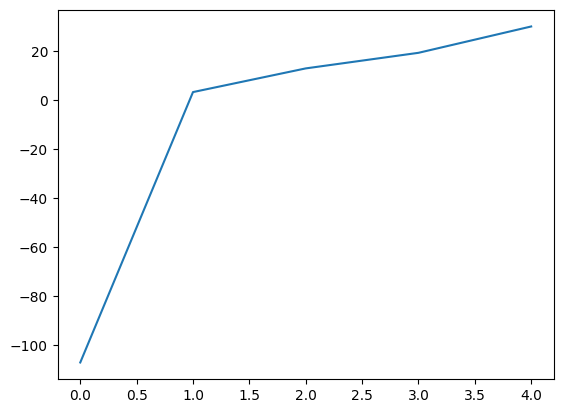

In [81]:
M = [10, 18.54, 26, 33.12, 40]
phi = [10, 10, 10, 10, 10]

x = SynthesizeFromHarmonics(M, phi)
plt.plot(x)
plt.show()

# 3.2.6.
Используя функцию из задания 3.2.5, выполните Фурье-анализ ЭКГ-сигнала. Постройте график сигнала во временной и частотной областях. 
По оси абсцисс в частотной области отложите аналоговые частоты.

# 3.2.7. 
Используйте функции из задания 3.2.5 и 3.2.6 для изменения тембра речевого сигнала. Для это запрограммируйте в Matlab следующий алгоритм:
˗ загрузите wav-файл при помощи функции [x, fs]=wavread('путь_к_файлу');
˗ входной сигнал разбейте на последовательные секции по 512 отсчетов;
˗ для каждой секции сигнала выполните ДПФ и найдите гармонические
параметры 𝑀𝑘 и𝜑𝑘;
˗ преобразуйте амплитуды гармоник 𝑀𝑘 при помощи функции ChangeTimbre(M_k,alpha), оставляя фазы гармоник неизменными. Параметр alpha влияет на степень изменения тембра:𝛼=1 – не изменит тембра, 𝛼>1– тембр становится более высоким, 𝛼<1– более низким. При 𝛼>2 и𝛼<0,5 в речевой сигнал может быть значительно искажен;
˗ выполните синтез секции речевого сигнала из параметров 𝑀𝑘 и 𝜑𝑘 при помощи функции из задания 3.2.6;
˗ запишите синтезированный речевой сигнал y в wav-файл при помощи функции wavwrite(y,fs,'имя_файла').

# Данные для задания 3.2.6 и 3.2.7 не были найдены

# 3.2.8. 
Выполните моделирование работы полупроводникового диода при прохождении через него синусоидального сигнала (рис. 3.15).

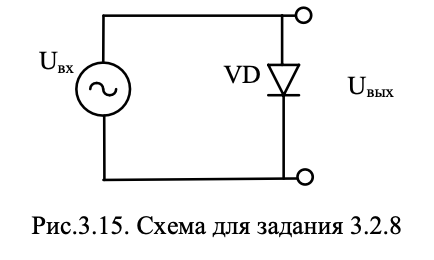

Выходное напряжение определяется следующим образом

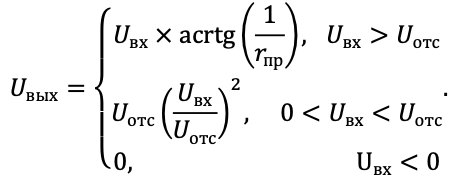

Постройте график выходного напряжения, если на входе действует сигнал

$$x(t) = 0.5 \sin (2 \pi 10 t), 0 < t < 0.5 c$$

Для получения дискретного сигнала
𝑥[𝑛] выполните дискретизацию сигнала с частотой 100 Гц. Постройте спектры входного (𝑥[𝑛]) и выходного сигнала 𝑦[𝑛]. Какие выводы можно сделать по внешнему виду полученных спектров?

In [121]:
Uotc = 0.7
r = 10
def OutputVoltage(x, Uotc, r, fs):
    y = np.zeros(len(x))

    for i in range(len(x)):
        if x[i] > Uotc:
            y[i] = (x[i] * np.arctan(1 / r))
        elif ((0 < x[i]) and (x[i] < Uotc)):
            y[i] = (Uotc * (x[i] / Uotc) ** 2)
        else:
            y[i] = 0
    
    return y

In [122]:
def DiscretizeSignal(x, fs):
    Ts = 1/fs
    n = np.arange(0, len(x))
    t = n*Ts
    return x, n, t

In [123]:
def Spectrum(signal, fs):
    N = len(signal)
    freq = fftfreq(N, 1/fs)
    spectrum = fft(signal)
    return freq, spectrum

In [127]:
def PlotSpectrum(signal, fs, i):
    freq, spectrum = Spectrum(signal, fs)
    pylab.subplot(3, 2, i)
    pylab.plot(freq, np.abs(spectrum), linestyle='-', color='b', linewidth=Linewidth)

In [128]:
# Входной сигнал x(t) = 0.5*sin(2*pi*10*t), 0 < t < 0.5 c
fs = 100  # Частота дискретизации 100 Гц
T = 0.5  # Длительность сигнала 0.5 с
t = np.arange(0, T, 1/fs)
x = 0.5 * np.sin(2 * np.pi * 10 * t)

# Дискретизация входного сигнала
x, n, t = DiscretizeSignal(x, fs)

# Вычисление выходного напряжения
y = OutputVoltage(x, Uotc, r, fs)

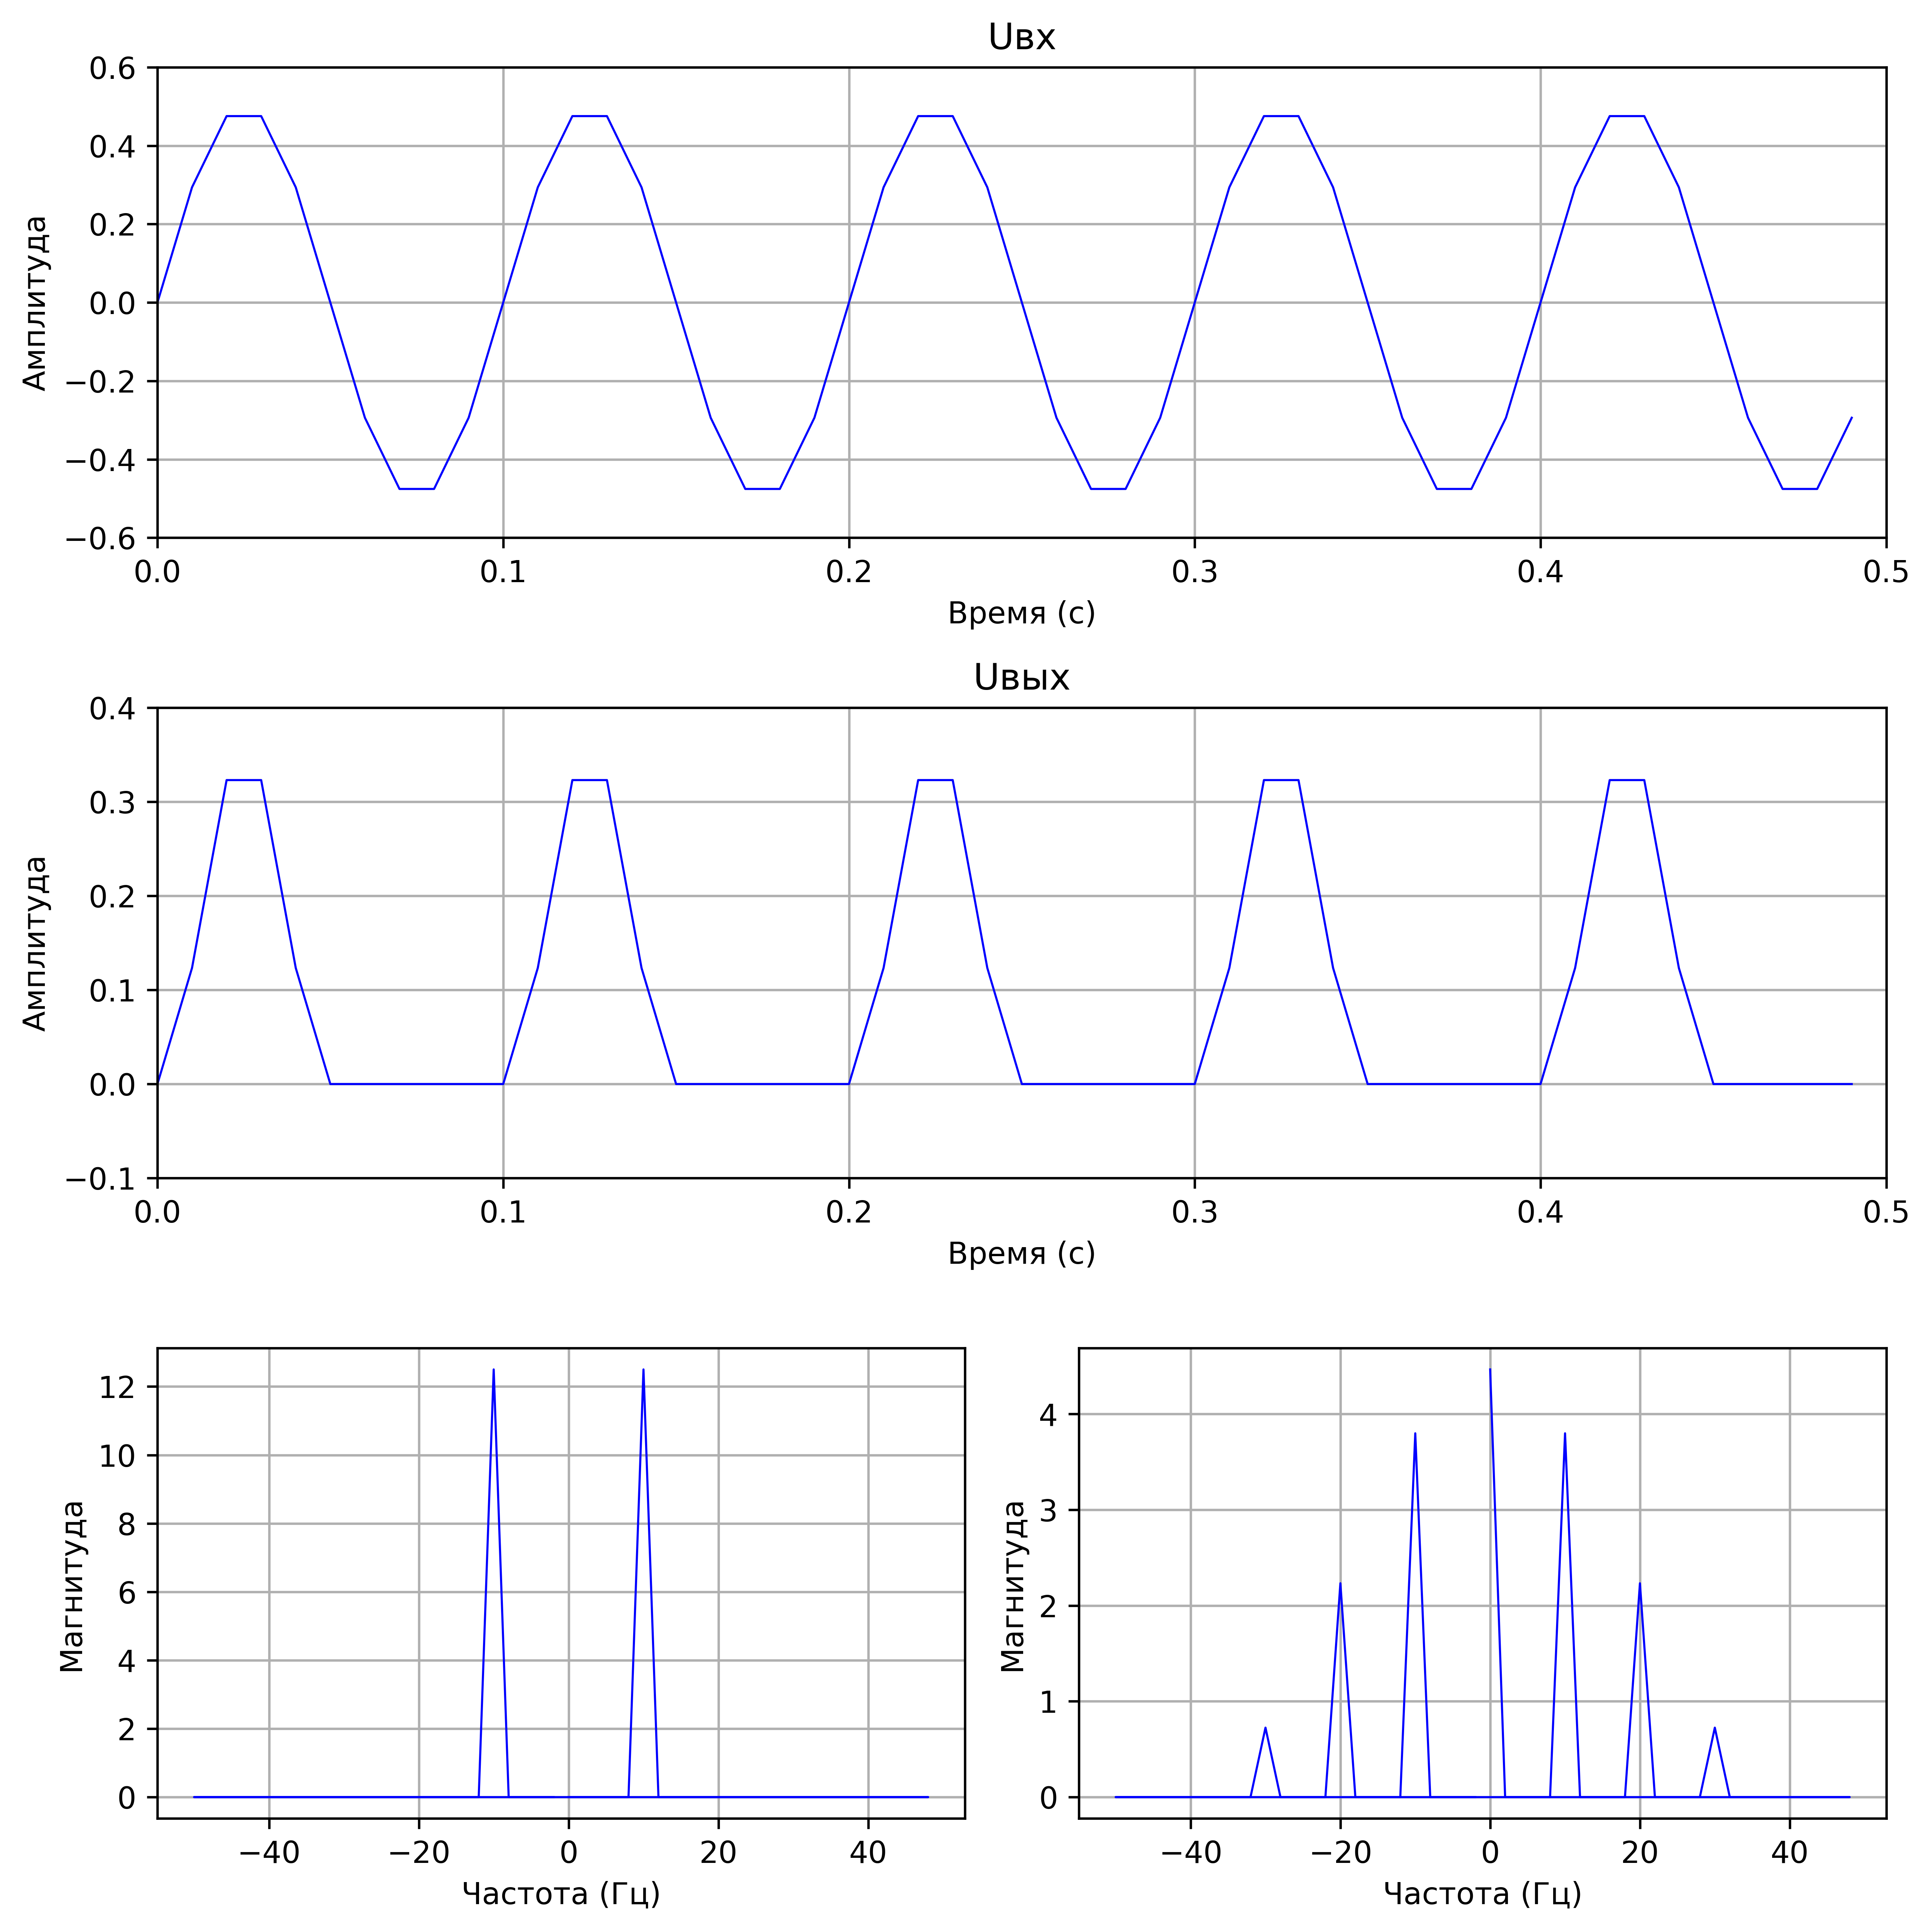

In [138]:
pylab.figure(figsize=(9.0, 9.0), dpi=600)
# Построение графиков входного и выходного напряжений
pylab.subplot(3, 1, 1)
pylab.plot(t, x, linestyle='-', color='b', linewidth=Linewidth)
pylab.grid()
pylab.xlim((0, 0.5))
pylab.xscale('linear')
pylab.ylim((-0.6, 0.6))
pylab.yscale('linear')
pylab.xlabel('Время (с)')
pylab.ylabel('Амплитуда')
pylab.title('Uвх')

pylab.subplot(3, 1, 2)
pylab.plot(t, y, linestyle='-', color='b', linewidth=Linewidth)
pylab.grid()
pylab.xlim((0, 0.5))
pylab.xscale('linear')
pylab.ylim((-0.1, 0.4))
pylab.yscale('linear')
pylab.xlabel('Время (с)')
pylab.ylabel('Амплитуда')
pylab.title('Uвых')

# Построение спектров входного и выходного сигналов
PlotSpectrum(x, fs, 5)
pylab.grid()
pylab.xlabel('Частота (Гц)')
pylab.ylabel('Магнитуда')

PlotSpectrum(y, fs, 6)
pylab.grid()
pylab.xlabel('Частота (Гц)')
pylab.ylabel('Магнитуда')

pylab.tight_layout()
pylab.savefig('mydiod.png', dpi=600)
pylab.show()